--> Using Gradient Boosting Regressor Model for Predicting Future Electricity Production values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('Electric_Production.csv')
data.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)

# Define the number of lags
n_lags = 20

In [3]:
def create_features(data, target_col, n_lags=12):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

In [4]:
supervised_data = create_features(data, target_col='Electric_Production', n_lags=n_lags)
X = supervised_data.drop(columns=['Electric_Production'])
Y = supervised_data['Electric_Production']

In [5]:
if 'DATE' in X.columns:
    X = X.drop(columns=['DATE'])

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [7]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

In [8]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
print(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

16.6831993728245
Root Mean Squared Error (RMSE): 4.08


In [9]:
y_pred

array([ 88.97841936,  94.62330065, 112.20794221, 118.26875917,
       108.19454405,  97.39348692,  88.90697667,  88.79894631,
       108.24582935, 115.20891172, 112.59124122,  98.84804199,
        89.81647119,  92.87218986, 105.80851349, 113.65076774,
       107.52321863,  94.48882643,  90.47200016,  94.40296336,
       105.35089608, 111.32296273, 106.77903747,  98.95877879,
        90.12013375,  95.27321312, 109.26730921, 115.68644329,
       108.50280967, 102.82312776,  90.36187921,  90.35289438,
       102.34828516, 111.51257373, 109.80903336,  98.51332625,
        91.19723428,  98.5919578 , 112.31103875, 116.28323896,
       111.11715639, 101.80255679,  90.96754674,  91.78495832,
       102.24482249, 112.20000735, 107.77302728, 102.62113257,
        92.31792025,  98.78433807, 109.2404243 , 117.70672173,
       114.22108327, 103.11970017,  89.81965525,  92.77679255,
       102.79160751, 113.51437656, 110.23162683, 101.36340118,
        91.1674506 ,  92.37391261, 108.67177235, 117.33

In [10]:
Y_test.values

array([ 90.3566,  93.8095, 107.3312, 111.9646, 103.3679,  93.5772,
        87.5566,  92.7603, 101.14  , 113.0357, 109.8601,  96.7431,
        90.3805,  94.3417, 105.2722, 115.501 , 106.734 , 102.9948,
        91.0092,  90.9634, 100.6957, 110.148 , 108.1756,  99.2809,
        91.7871,  97.2853, 113.4732, 124.2549, 112.8811, 104.7631,
        90.2867,  92.134 , 101.878 , 108.5497, 108.194 , 100.4172,
        92.3837,  99.7033, 109.3477, 120.2696, 116.3788, 104.4706,
        89.7461,  91.093 , 102.6495, 111.6354, 110.5925, 101.9204,
        91.5959,  93.0628, 103.2203, 117.0837, 106.6688,  95.3548,
        89.3254,  90.7369, 104.0375, 114.5397, 115.5159, 102.7637,
        91.4867,  92.89  , 112.7694, 114.8505,  99.4901, 101.0396,
        88.353 ,  92.0805, 102.1532, 112.1538, 108.9312,  98.6154,
        93.6137,  97.3359, 114.7212, 129.4048])

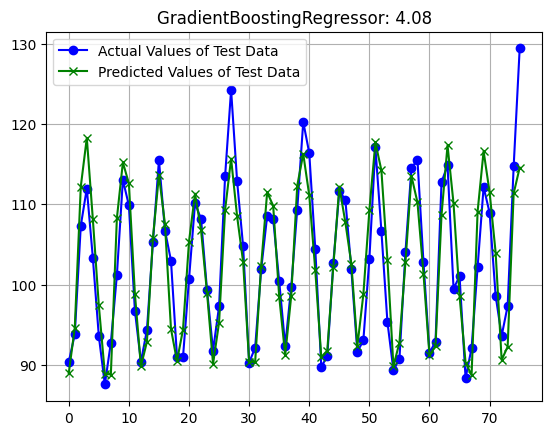

In [20]:
plt.plot(figsize=(12,6))
plt.title('GradientBoostingRegressor: 4.08')
plt.plot(Y_test.values, color='blue', marker='o', label='Actual Values of Test Data')
plt.plot(y_pred, color='green', marker='x', label='Predicted Values of Test Data')
plt.legend()
plt.grid()
plt.show()

In [12]:
start_date = pd.to_datetime('2018-02-01')
end_date = pd.to_datetime('2019-01-01')
future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')  # Monthly start frequency

# Prepare the last known values (lags) from the dataset
last_values = data['Electric_Production'][-n_lags:].values[::-1]

# Initialize a list to store predictions
future_predictions = []

# Iteratively predict for each future date
for date in future_dates:
    # Create a feature vector using the most recent lag values
    future_features = {f'lag_{i+1}': last_values[i] for i in range(n_lags)}
    feature_df = pd.DataFrame([future_features])
    
    # Predict the value for the current date
    prediction = model.predict(feature_df)[0]
    future_predictions.append(prediction)
    
    # Update the lag values
    last_values = np.roll(last_values, shift=1)  # Shift values to the right
    last_values[0] = prediction  # Add the new prediction as the most recent lag

# Create a DataFrame to store the results
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Electric_Production': future_predictions
})

# Display predictions
print(future_df)

# Save the future_df DataFrame to a CSV file
future_df.to_csv('future_predictions.csv', index=False)

         Date  Predicted_Electric_Production
0  2018-02-01                     104.855194
1  2018-03-01                     100.041291
2  2018-04-01                      90.222411
3  2018-05-01                      92.957402
4  2018-06-01                     103.315545
5  2018-07-01                     112.897767
6  2018-08-01                     109.388305
7  2018-09-01                      97.971806
8  2018-10-01                      92.454363
9  2018-11-01                     101.602687
10 2018-12-01                     116.610826
11 2019-01-01                     115.054086


In [13]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [14]:
data['DATE']

0     1985-01-01
1     1985-02-01
2     1985-03-01
3     1985-04-01
4     1985-05-01
         ...    
392   2017-09-01
393   2017-10-01
394   2017-11-01
395   2017-12-01
396   2018-01-01
Name: DATE, Length: 397, dtype: datetime64[ns]

In [15]:
future_df['Date']

0    2018-02-01
1    2018-03-01
2    2018-04-01
3    2018-05-01
4    2018-06-01
5    2018-07-01
6    2018-08-01
7    2018-09-01
8    2018-10-01
9    2018-11-01
10   2018-12-01
11   2019-01-01
Name: Date, dtype: datetime64[ns]

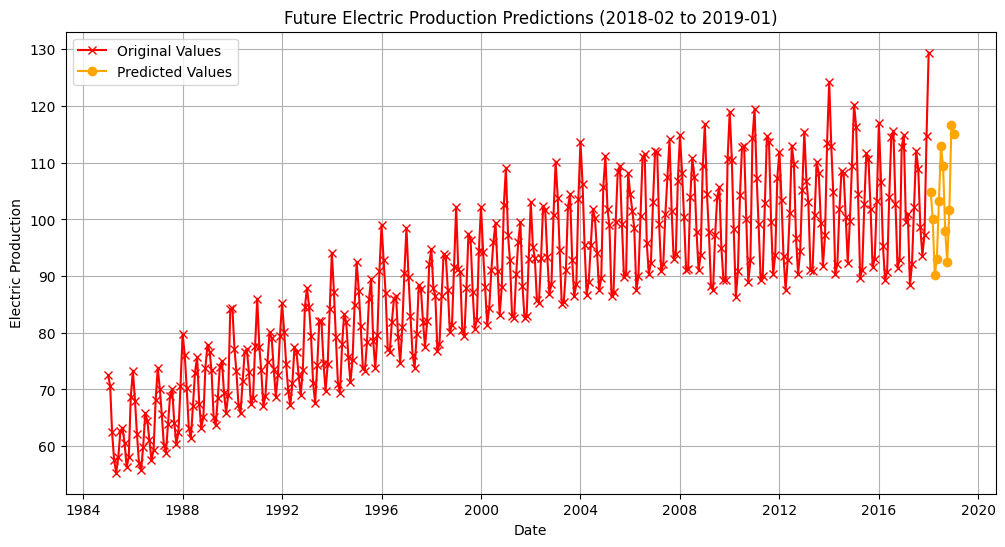

In [16]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(data['DATE'], data['Electric_Production'], label='Original Values', marker='x', color='red')
plt.plot(future_df['Date'], future_df['Predicted_Electric_Production'], label='Predicted Values', marker='o', color='orange')
plt.title('Future Electric Production Predictions (2018-02 to 2019-01)')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.grid()
plt.legend()
plt.show()

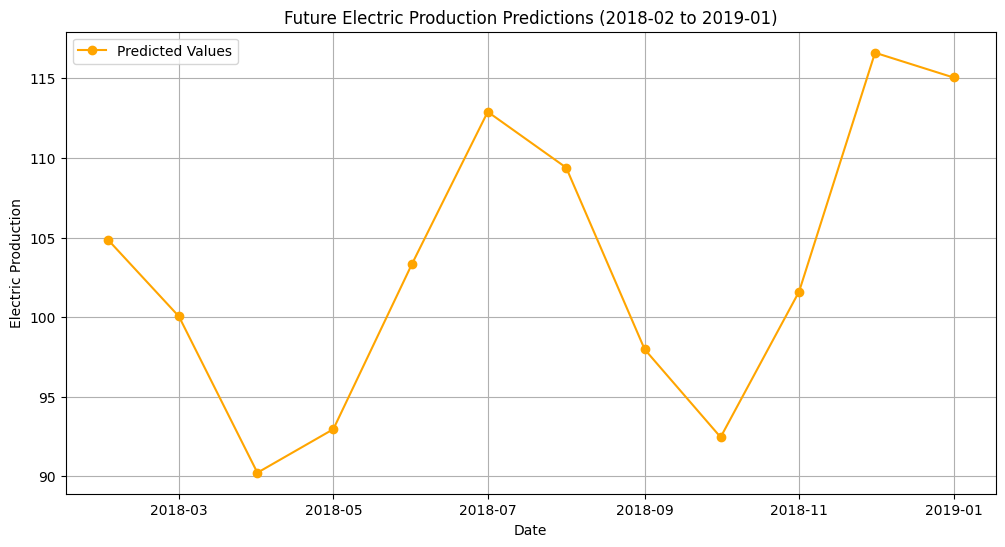

In [17]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_df['Date'], future_df['Predicted_Electric_Production'], label='Predicted Values', marker='o', color='orange')
plt.title('Future Electric Production Predictions (2018-02 to 2019-01)')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.grid()
plt.legend()
plt.show()